In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import gradio as gr
from PIL import Image
import pickle



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

Usando: cuda


In [3]:
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

#Dataset
trainset_raw = datasets.CIFAR100(root='./data', train=True, download=True, transform=raw_transform)
loader = DataLoader(trainset_raw, batch_size=50000, shuffle=False)

data = next(iter(loader))[0]# Tomar los datos

# Calcular por canal
mean = data.mean(dim=(0, 2, 3))
std = data.std(dim=(0, 2, 3))

print("Media por canal:", mean)
print("Desviación estándar por canal:", std)


Media por canal: tensor([0.5071, 0.4866, 0.4409])
Desviación estándar por canal: tensor([0.2673, 0.2564, 0.2762])


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes
superclasses = trainset.class_to_idx  # Relación de clases


ResNet

In [5]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)  # Capa de salida de 100 clases

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
def mostrar_prediccion(modelo, dataloader, classes):
    modelo.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(5):
            img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
            plt.imshow(img)
            plt.title(f"Real: {classes[labels[i]]} - Predicho: {classes[predicted[i]]}")
            plt.axis('off')
            plt.show()


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0
patience = 5
trigger_times = 0

train_losses = []
train_accuracies = []

for epoch in range(30):  # Número de épocas
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Época {epoch+1}, Precisión: {acc*100:.2f}%")

    # Pa Early stopping y checkpoint
    if acc > best_acc:
        best_acc = acc
        trigger_times = 0
        torch.save(model.state_dict(), "mejor_modelo.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activado")
            break



Época 1, Precisión: 22.48%
Época 2, Precisión: 31.38%
Época 3, Precisión: 37.24%
Época 4, Precisión: 40.75%
Época 5, Precisión: 42.24%
Época 6, Precisión: 45.13%
Época 7, Precisión: 44.46%
Época 8, Precisión: 45.07%
Época 9, Precisión: 45.52%
Época 10, Precisión: 45.74%
Época 11, Precisión: 44.49%
Época 12, Precisión: 44.93%
Época 13, Precisión: 43.99%
Época 14, Precisión: 44.76%
Época 15, Precisión: 44.63%
Early stopping activado


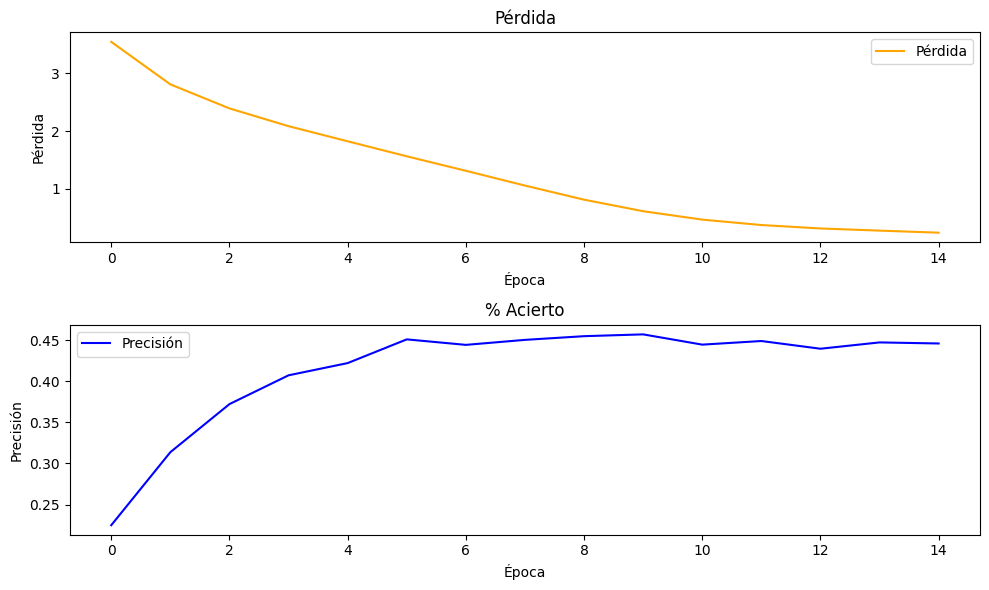

In [8]:
# Gráfico de pérdida y precisión por época
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label="Pérdida", color='orange')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label="Precisión", color='blue')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("% Acierto")
plt.legend()

plt.tight_layout()
plt.show()


MLP

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)  # 100 clases CIFAR-100

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp_model = MLP().to(device)


In [10]:
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

best_acc_mlp = 0.0
patience = 5
trigger_times = 0

mlp_losses = []
mlp_accuracies = []

for epoch in range(30):  # Número de épocas
    mlp_model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mlp.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion_mlp(outputs, labels)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    mlp_losses.append(avg_loss)

    # Evaluación
    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    mlp_accuracies.append(acc)
    print(f"[MLP] Época {epoch+1}, Precisión: {acc*100:.2f}%")

    if acc > best_acc_mlp:
        best_acc_mlp = acc
        trigger_times = 0
        torch.save(mlp_model.state_dict(), "mejor_modelo_mlp.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activado (MLP)")
            break


[MLP] Época 1, Precisión: 16.81%
[MLP] Época 2, Precisión: 18.12%
[MLP] Época 3, Precisión: 19.81%
[MLP] Época 4, Precisión: 20.23%
[MLP] Época 5, Precisión: 20.84%
[MLP] Época 6, Precisión: 21.40%
[MLP] Época 7, Precisión: 21.86%
[MLP] Época 8, Precisión: 21.82%
[MLP] Época 9, Precisión: 22.22%
[MLP] Época 10, Precisión: 21.73%
[MLP] Época 11, Precisión: 20.80%
[MLP] Época 12, Precisión: 21.87%
[MLP] Época 13, Precisión: 21.79%
[MLP] Época 14, Precisión: 22.18%
Early stopping activado (MLP)


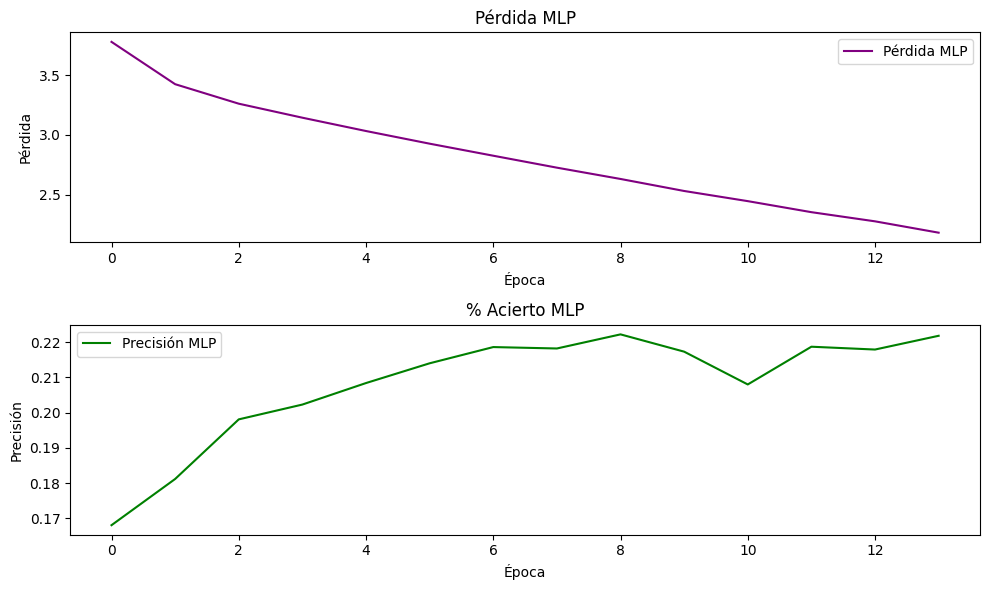

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(mlp_losses, label="Pérdida MLP", color='purple')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida MLP")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(mlp_accuracies, label="Precisión MLP", color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("% Acierto MLP")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
def evaluar_modelo(modelo, path_pesos, nombre="Modelo"):
    modelo.load_state_dict(torch.load(path_pesos))
    modelo.to(device)
    modelo.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n🔍 Resultados para {nombre}")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
    print(f"Precision macro: {precision_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"Recall macro: {recall_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"F1-score macro: {f1_score(all_labels, all_preds, average='macro'):.4f}")
    print("\nResumen por clase:")
    print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Evaluar ResNet
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 100)
evaluar_modelo(resnet_model, "mejor_modelo.pth", nombre="ResNet")

# Evaluar MLP
mlp_model_eval = MLP()
evaluar_modelo(mlp_model_eval, "mejor_modelo_mlp.pth", nombre="MLP")



🔍 Resultados para ResNet
Accuracy: 45.74%
Precision macro: 0.4731
Recall macro: 0.4574
F1-score macro: 0.4576

Resumen por clase:
               precision    recall  f1-score   support

        apple       0.67      0.74      0.70       100
aquarium_fish       0.57      0.46      0.51       100
         baby       0.25      0.36      0.30       100
         bear       0.35      0.19      0.25       100
       beaver       0.35      0.19      0.25       100
          bed       0.49      0.52      0.50       100
          bee       0.36      0.47      0.41       100
       beetle       0.64      0.36      0.46       100
      bicycle       0.54      0.58      0.56       100
       bottle       0.64      0.52      0.57       100
         bowl       0.29      0.46      0.36       100
          boy       0.31      0.29      0.30       100
       bridge       0.43      0.40      0.41       100
          bus       0.39      0.31      0.34       100
    butterfly       0.43      0.43      0.4

In [13]:

# Cargar modelo entrenado
modelo = models.resnet18(pretrained=False)
modelo.fc = nn.Linear(modelo.fc.in_features, 100)
modelo.load_state_dict(torch.load("mejor_modelo.pth", map_location=device))
modelo.to(device)
modelo.eval()

# Transformación igual a la usada en el dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Cargar nombres de clases y superclases desde el archivo meta
with open('./data/cifar-100-python/meta', 'rb') as infile:
    meta = pickle.load(infile, encoding='latin1')

fine_label_names = meta['fine_label_names']
coarse_label_names = meta['coarse_label_names']

# Mapeo clase fina → superclase (usando archivo train)
with open('./data/cifar-100-python/train', 'rb') as infile:
    train_data = pickle.load(infile, encoding='latin1')

fine_to_coarse = {}
for fine, coarse in zip(train_data['fine_labels'], train_data['coarse_labels']):
    if fine not in fine_to_coarse:
        fine_to_coarse[fine] = coarse

# Función de predicción con clase y superclase
def predecir(imagen):
    imagen = imagen.resize((32, 32))
    entrada = transform(imagen).unsqueeze(0).to(device)
    with torch.no_grad():
        salida = modelo(entrada)
        pred = salida.argmax(dim=1).item()

    clase = fine_label_names[pred]
    superclase = coarse_label_names[fine_to_coarse[pred]]
    return f"🟦 Clase: {clase}\n🟥 Superclase: {superclase}"

# Interfaz Gradio
demo = gr.Interface(
    fn=predecir,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Clasificador CIFAR-100 (ResNet)",
    description="Carga una imagen (32x32) y te dirá la clase y superclase predicha por el modelo entrenado."
)

demo.launch()


c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Para probar en el notebook

In [2]:
import os
import urllib.request
import tarfile

# Crear carpeta si no existe
os.makedirs('./data', exist_ok=True)

# URL del dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "./data/cifar-100-python.tar.gz"

# Descargar si no existe
if not os.path.exists(filename):
    print("Descargando CIFAR-100...")
    urllib.request.urlretrieve(url, filename)
    print("Descarga completa.")

# Descomprimir
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall(path="./data")
    print("Dataset extraído.")


Dataset extraído.


In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import gradio as gr
from PIL import Image
import pickle

# Configurar transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Cargar modelo ResNet18 y pesos entrenados
modelo = models.resnet18(num_classes=100)
modelo.load_state_dict(torch.load('mejor_modelo.pth', map_location='cpu'))
modelo.eval()

# Cargar nombres de clases
with open('./data/cifar-100-python/meta', 'rb') as infile:
    meta = pickle.load(infile, encoding='latin1')
    fine_label_names = meta['fine_label_names']

# Función de predicción
def predict(image):
    image = transform(image).unsqueeze(0)
    outputs = modelo(image)
    _, predicted = torch.max(outputs.data, 1)
    return fine_label_names[predicted.item()]

# Lanzar Gradio
demo = gr.Interface(fn=predict, inputs=gr.Image(), outputs="label")
demo.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
